Helper Functions for RL

In [ ]:
#@title
import numpy as np
import jax.numpy as jnp
import jax
np.random.seed(1)

# RUNNING SHAPE ASSUMPTIONS
# P.shape = (n_states, n_actions, n_states)
# r.shape = (n_states, n_actions)
# pi.shape = (n_states, n_actions) ## in certain state, the probability that policy pi leads to certain action

# Calculating value functions
def get_P_pi(P, pi):
    return jnp.sum(P * jnp.expand_dims(pi, axis = -1), axis = 1)

def get_V(P, r, gamma, pi):
    P_pi = get_P_pi(P, pi)
    r_pi = jnp.sum(r * pi, axis = -1)
    # v is the vector such that (I - gamma P_pi) v = r_pi
    return jnp.linalg.solve(jnp.eye(pi.shape[0]) - gamma * P_pi, r_pi)

def get_Q(P, r, gamma, pi):
    n_states = P.shape[0]
    V = get_V(P, r, gamma, pi)
    Vp =  jnp.sum(P * V.reshape((1, 1, n_states)), axis = -1)
    return r + gamma * Vp

def get_soft_V(P, r, gamma, pi, tau):
    P_pi = get_P_pi(P, pi)
    r_pi = np.sum(r * pi, axis = -1) - tau * np.sum(pi * np.log(pi), axis = 1)
    return jnp.linalg.solve(jnp.eye(pi.shape[0]) - gamma * P_pi, r_pi)

def get_soft_Q(P, r, gamma, pi, tau):
    n_states = P.shape[0]
    V = get_soft_V(P, r, gamma, pi, tau)
    Vp =  jnp.sum(P * V.reshape((1, 1, n_states)), axis = -1)
    return r + gamma * Vp


# Misc RL procedures
def value_iteration(P, r, gamma, V, iters = 1):
    n_states = P.shape[0]
    res = V
    for _ in range(iters):
        Vp =  jnp.sum(P * res.reshape((1, 1, n_states)), axis = -1)
        res = jnp.max(r + gamma * Vp, axis = -1)
        assert jnp.shape(res)[0] == n_states
        assert len(res[res != res]) == 0
    return res

def get_optimal_V(P, r, gamma, iters = int(1e5)):
    return value_iteration(P, r, gamma, np.zeros(P.shape[0]), iters)

def action_value_iteration(P, r, gamma, Q, iters = 1):
    n_states = P.shape[0]
    n_actions = r.shape[1]
    res = Q
    for _ in range(iters):
        max_Q = jnp.max(res, axis = -1).reshape((1, 1, n_states))
        res = r + gamma * jnp.sum(max_Q * P, axis = -1)
        assert res.shape == (n_states, n_actions), res.shape
    return res

def get_optimal_Q(P, r, gamma, iters = int(1e5)):
    n_states = P.shape[0]
    n_actions = r.shape[1]
    Q = np.zeros((n_states, n_actions))
    return action_value_iteration(P, r, gamma, Q, iters = iters)

def get_greedy_pi(Q):
    n_states = Q.shape[0]
    n_actions = Q.shape[1]
    # extract greedy policy from Q
    max_actions =  jnp.argmax(Q, axis = -1)
    pi = np.zeros((n_states, n_actions))
    for i in range(n_states):
        pi[i, max_actions[i]] = 1
    return pi


def get_d_pi(P, gamma, pi, rho):
    # d_pi = (1 - gamma) (I - \gamma P.T)^{-1} \rho
    n_states = P.shape[0]
    P_pi = get_P_pi(P, pi)
    # d_pi is the vector such that (I - \gamma P_pi.T) d_pi = (1 - gamma) * \rho
    return jnp.linalg.solve(jnp.eye(n_states) - gamma * P_pi.T, (1 - gamma) * rho)

MDP with Low Rank Structure

In [ ]:
def build_low_rank_mdp(d, p, K, L, R=1.0, epsilon=0.15):
    P=np.zeros((2*K*d+2,2*L,2*K*d+2))
    r=np.zeros((2*K*d+2,2*L))
    for i in range(d-1):
        for j in range(K):
            for k in range(L):
                P[i*K+j,k,i*K:(i+1)*K]=(1-p)*np.random.dirichlet(np.ones(K),size=1)
                P[i*K+j,k,(i+1)*K:(i+2)*K]=p*np.random.dirichlet(np.ones(K),size=1)
                P[i*K+j,L+k,(d+i)*K:(d+i+1)*K]=(1-p)*np.random.dirichlet(np.ones(K),size=1)
                P[i*K+j,L+k,(d+i+1)*K:(d+i+2)*K]=p*np.random.dirichlet(np.ones(K),size=1)
                P[(d+i)*K+j,k,(d+i)*K:(d+i+1)*K]=(1-p)*np.random.dirichlet(np.ones(K),size=1)
                P[(d+i)*K+j,k,(d+i+1)*K:(d+i+2)*K]=p*np.random.dirichlet(np.ones(K),size=1)
                P[(d+i)*K+j,L+k,(d+i)*K:(d+i+1)*K]=(1-p)*np.random.dirichlet(np.ones(K),size=1)
                P[(d+i)*K+j,L+k,(d+i+1)*K:(d+i+2)*K]=p*np.random.dirichlet(np.ones(K),size=1)
    for j in range(K):
        P[(d-1)*K+j,:,2*K*d]=0.5+epsilon
        P[(d-1)*K+j,:,2*K*d+1]=0.5-epsilon
        P[(2*d-1)*K+j,:,2*K*d]=0.5
        P[(2*d-1)*K+j,:,2*K*d+1]=0.5
    P[2*K*d,:,2*K*d+1]=1
    P[2*K*d+1,:,2*K*d+1]=1
    r[2*K*d,:]=R
    return P, r

d=10
p=0.65
K=10
L=10
R=100.0
epsilon=0.40
gamma=2*d/(2*d+1)
P,r=build_low_rank_mdp(d,p,K,L,R,epsilon)
rho=np.zeros(2*K*d+2)
#rho[:K]=np.random.dirichlet(np.ones(K),size=1)
rho[:K]=1.0/K

Use Q*(s,a) as features

In [ ]:
Q_approx=np.zeros((2*d+2,2))
Q_approx[2*d,:]=np.array([R,R])
Q_approx[2*d-1,:]=np.array([0.5*gamma*R,0.5*gamma*R])
for i in range(2*d-2,d-1,-1):
    Q_approx[i,:]=Q_approx[i+1,:]*p*gamma/(1-gamma+p*gamma)
Q_approx[d-1,:]=np.array([(0.5+epsilon)*gamma*R,(0.5-epsilon)*gamma*R])
for i in range(d-2,-1,-1):
    Q_approx[i,0]=Q_approx[i+1,0]*p*gamma/(1-gamma+p*gamma)
    Q_approx[i,1]=(1-p)*gamma*Q_approx[i+d,0]+p*gamma*Q_approx[i+d+1,0]

In [ ]:
Q_approx # This is Q*(s,a)

array([[ 43.99375785,  24.44097658],
       [ 47.37789307,  26.3210517 ],
       [ 51.02234638,  28.34574799],
       [ 54.94714226,  30.52619014],
       [ 59.17384551,  32.87435861],
       [ 63.72567978,  35.40315543],
       [ 68.62765514,  38.12647508],
       [ 73.90670554,  41.05928086],
       [ 79.59183673,  44.21768707],
       [ 85.71428571,   9.52380952],
       [ 24.44097658,  24.44097658],
       [ 26.3210517 ,  26.3210517 ],
       [ 28.34574799,  28.34574799],
       [ 30.52619014,  30.52619014],
       [ 32.87435861,  32.87435861],
       [ 35.40315543,  35.40315543],
       [ 38.12647508,  38.12647508],
       [ 41.05928086,  41.05928086],
       [ 44.21768707,  44.21768707],
       [ 47.61904762,  47.61904762],
       [100.        , 100.        ],
       [  0.        ,   0.        ]])

Create Feature for the MDP Problem

In [ ]:
phi=np.zeros((2*K*d+2,L*2))
for i in range(d):
    for j in range(2):
        for k in range(K):
            for l in range(L):
                phi[i*K+k,j*L+l]=Q_approx[i,j]
                phi[(i+d)*K+k,j*L+l]=Q_approx[i+d,j]
for j in range(2):
    for l in range(L):
        phi[2*K*d,j*L+l]=Q_approx[2*d,j]
        phi[2*K*d+1,j*L+l]=Q_approx[2*d+1,j]

Or, Set Good State Action Pair to 1?

In [ ]:
phi=np.zeros((2*K*d+2,L*2))
for i in range(d):
    for j in range(K):
        for k in range(L):
            phi[i*K+j,k]=1

In [ ]:
def nabula_log_pi(s,a,theta,phi):
    return phi[s,a]-np.sum(np.exp(phi[s]*theta)*phi[s])/np.sum(np.exp(phi[s]*theta))

In [ ]:
def get_pi(theta,phi,S,A):
    pi=np.zeros((S,A))
    for i in range(S):
        pi[i]=np.exp(theta*phi[i])/np.sum(np.exp(theta*phi[i]))
    return pi

In [ ]:
def fisher_information_matrix(theta,phi,S,A,P,gamma,rho):
    ret=0
    pi=get_pi(theta,phi,S,A)
    #print("pi=",pi)
    d_pi=get_d_pi(P, gamma, pi, rho)
    #print("dpi=",d_pi)
    for s in range(S):
        for a in range(A):
            grad=nabula_log_pi(s,a,theta,phi)
            #mat=grad@grad.T
            mat=grad*grad
            ret=ret+d_pi[s]*pi[s,a]*mat
    return ret

In [ ]:
import jax

import matplotlib
from matplotlib import pyplot as plt

# make fonts of pyplot bigger
matplotlib.rcParams.update({'font.size': 10})

@jax.jit
def true_gradient(P, r, gamma, theta, phi, rho):
    pi=jax.nn.softmax(theta*phi, axis = 1)
    d_pi = jax.lax.stop_gradient(get_d_pi(P, gamma, pi, rho))
    qpi = jax.lax.stop_gradient(get_Q(P, r, gamma, pi))
    grad = jax.grad(
        lambda theta: np.sum(d_pi * np.sum(qpi * jax.nn.softmax(theta*phi, axis = 1), axis = 1))
    )(theta)
    return grad / (1 - gamma)

In [ ]:
def policy_objective(P, r, gamma, pi, rho):
  v_pi = get_V(P, r, gamma, pi)
  return jnp.sum(v_pi * rho)

In [ ]:
def run_policy_gradient(P, r, gamma, theta, phi, rho, mu, lr, T, callback = None):
  performance = np.zeros(T)
  surrogate_performance = np.zeros(T)
  S,A=phi.shape
  # run policy gradient for T timesteps, updating at every time step
  for t in range(T):
    print(t)
    pi = jax.nn.softmax(theta*phi, axis = 1)
    print(pi)
    # record performance with respect to the original objective V^\theta(s_0)
    performance[t] = policy_objective(P, r, gamma, pi, rho)

    # record performance with respect to the surrogate objective J_\mu(\pi)
    surrogate_performance[t] = policy_objective(P, r, gamma, pi, mu)

    # callback for recording data
    #if callback is not None:
    #  callback(P, r, gamma, logits, rho, mu, pi, t)

    # take a gradient step with respect to the surrogate objective J_\mu(\pi)
    #print("grad")
    #print(true_gradient(P, r, gamma, theta, phi, mu))
    #print(true_gradient(P, r, gamma, theta, phi, mu).shape)
    #print(fisher_information_matrix(theta,phi,S,A,P,gamma,rho))
    #print(fisher_information_matrix(theta,phi,S,A,P,gamma,rho).shape)
    FIM=fisher_information_matrix(theta,phi,S,A,P,gamma,rho)
    print("FIM=",FIM)
    if FIM<1e-6:
        T=t+1
        return (performance, surrogate_performance,T)
    theta = theta + lr * 1 / FIM * true_gradient(P, r, gamma, theta, phi, mu)
  return (performance, surrogate_performance,T)

In [ ]:
perf1,perf2,T=run_policy_gradient(P,r,gamma,0.0,phi,rho,rho,0.01,100)

0
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
FIM= 0.022725737
1
[[0.05030449 0.05030449 0.05030449 ... 0.04969551 0.04969551 0.04969551]
 [0.05030449 0.05030449 0.05030449 ... 0.04969551 0.04969551 0.04969551]
 [0.05030449 0.05030449 0.05030449 ... 0.04969551 0.04969551 0.04969551]
 ...
 [0.05       0.05       0.05       ... 0.05       0.05       0.05      ]
 [0.05       0.05       0.05       ... 0.05       0.05       0.05      ]
 [0.05       0.05       0.05       ... 0.05       0.05       0.05      ]]
FIM= 0.022851365
2
[[0.05062621 0.05062621 0.05062621 ... 0.04937379 0.04937379 0.04937379]
 [0.05062621 0.05062621 0.05062621 ... 0.04937379 0.04937379 0.04937379]
 [0.05062621 0.05062621 0.05062621 ... 0.04937379 0.04937379 0.04937379]
 ...
 [0.05       0.05       0.05       ... 0.05       0.05       0.0

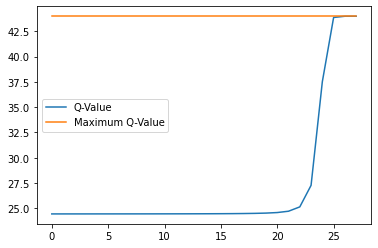

In [ ]:
import matplotlib.pyplot as plt
plt.plot(perf1[:T],label='Q-Value')
plt.plot(Q_approx[0][0]*np.ones(perf1[:T].shape),label='Maximum Q-Value')
plt.legend()
plt.show()